In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from configparser import ConfigParser
import pathlib as pl

import joblib as jl
import numpy as np
import xarray as xr
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from webcolors import name_to_hex

from src.data.rasters import load_site_formated_raster
from src.root_path import config_path, root_path
from src.utils.subsets import good_sites
from src.metrics.simple_diff import ctx_effects_as_DF

from src.models.decoder import unfold_rep_ctx_prb, get_svm_accuracy, decode_and_plot
from src.data.diagonalization import get_diagonalizations, plot_eg_diag, diag_and_scale
from src.visualization.palette import add_opacity

from src.visualization.interactive import plot_site_coverages, plot_raw_pair_array
from src.visualization.palette import Grey, FOURCOLOR, TENCOLOR

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))


[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2023-03-07 155053.log


cannot connect to database, loading hardcoded sites
cannot connect to database, loading hardcoded cells. TODO!


# purpose
after a first exploration of alternatives for densifying the naturally sparse contextual effects, we have simply
forced the response of all neurons to be equal for any given context (once the probe effect is subtracted),
while at the same time preserving the total response across all neurons.

For example, in a system of 2 neurons, x and y,
their original response to the context i are different: xi != yi and
xi + yi = A, where A is the total activity level.

After the densification, the modified responses are equal and the total
activity is preserved: xi == yi == A/2

xi == yi defines a diagonal, thus we name this specific approach of densification a **diagonalization**


this notebook presents a refactoring and functionalization of the diagoalization procedure, so we can apply it across
all the sites in our dataset


In [3]:
# Kinda baseline minimal parameterse
raster_meta = {'reliability': 0.1,  # r value
               'smoothing_window': 0,  # ms
               'raster_fs': 20,
               'zscore': True,
               'stim_type': 'permutations'}

# example from figure 1?
eg_prb = 3
eg_ctx_pair = [0,1]
eg_cellid = 'ARM021b-36-8'
eg_site = eg_cellid.split('-')[0]

# load cache of sigle cell rasters for this example site
if load_site_formated_raster.check_call_in_cache(eg_site, **raster_meta):
    raster, cellids = load_site_formated_raster(eg_site, **raster_meta)
    print(f'####\n'
          f'found and loaded cache for {eg_site}')
else:
    print(f"cant load load_site_formated_raster with {raster_meta}.\n this should be cached, why is it failing? ")


# small data subset with 2 neurons, 1 probe, and 1 timepoint, usefull for development and debuging
test_raster = raster[:,np.asarray([19,21]),...][...,0,0][:,:,:,None,None] # 2 neurons, 1 probe, 1 time point

####
found and loaded cache for ARM021b


square of negative 53
div by 0 in ClustVar 606


/home/mateo/code/context_probe_analysis/src/data/diagonalization.py:94: RuntimeWarning: divide by zero encountered in true_divide
  Sc = np.sqrt((TarVar - (Sm ** 2 * MeanVar)) / ClustVar)
/home/mateo/code/context_probe_analysis/src/data/diagonalization.py:94: RuntimeWarning: invalid value encountered in sqrt
  Sc = np.sqrt((TarVar - (Sm ** 2 * MeanVar)) / ClustVar)


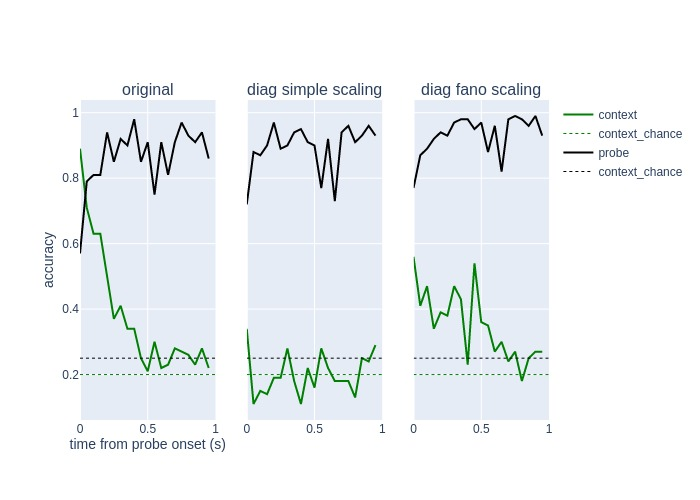

In [4]:
diag_simple_scaling = diag_and_scale(raster, mode='mean_var')
diag_fano_scaling = diag_and_scale(raster, mode='fano_var')

fig = make_subplots(rows=1, cols=3, shared_yaxes='all', shared_xaxes='all',
                    subplot_titles=['original', 'diag simple scaling', 'diag fano scaling'])

for cc, arr in enumerate([raster, diag_simple_scaling, diag_fano_scaling]):
    showlegend = True if cc == 0 else False
    f, _, _ = decode_and_plot(arr,showlegend=showlegend)
    f = f['data']
    fig.add_traces(f, rows=[1]*len(f), cols=[cc+1]*len(f))

_ = fig.update_xaxes(title_text='time from probe onset (s)', title_standoff=0, row=1, col=1)
_ = fig.update_yaxes(title_text='accuracy', title_standoff=0, row=1, col=1)

fig.show(renderer='jpeg')

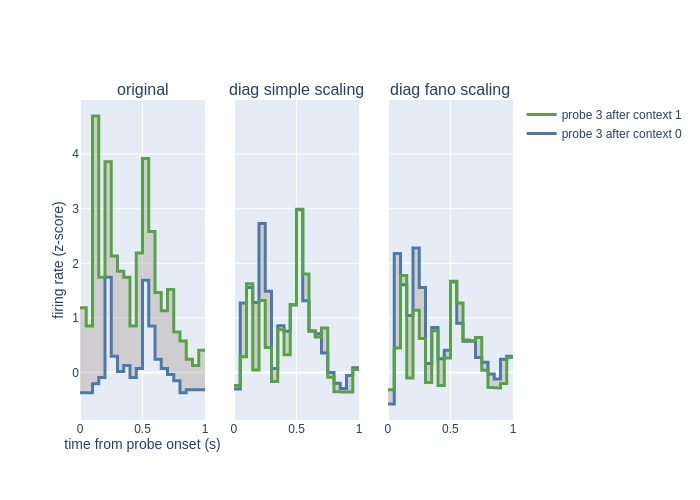

In [5]:
fig = make_subplots(rows=1, cols=3, shared_yaxes='all', shared_xaxes='all',
                    subplot_titles=['original', 'diag simple scaling', 'diag fano scaling'])


for cc, arr in enumerate([raster, diag_simple_scaling, diag_fano_scaling]):
    showlegend = True if cc == 0 else False
    f = plot_raw_pair_array(arr, cellids, eg_cellid, eg_ctx_pair, eg_prb, raster_meta['raster_fs'],
                    part='probe', hightlight_difference=True, CI=None, showlegend=showlegend)['data']
    fig.add_traces(f, rows=[1]*len(f), cols=[cc+1]*len(f))

_ = fig.update_xaxes(title_text='time from probe onset (s)', title_standoff=0, row=1, col=1)
_ = fig.update_yaxes(title_text='firing rate (z-score)', title_standoff=0, row=1, col=1)

fig.show(renderer='jpeg')

#### problematic instanceses
we have found that the fano scaling of diagonalization might fail for numerical reasons, here we disect these reasons:
likely zero variance. and the consequencess it has over the final diagonalization

In [27]:
simple_diag, (Sm, Sc) = diag_and_scale(raster, mode='mean_var', return_problem=False)
fano_diag, (Sm, Sc) = diag_and_scale(raster, mode='fano_var', return_problem=True)

print(Sm.shape)
print(f"problems in mean scaler:{np.any(Sm)}")
print(f"problems in cluster scaler:{np.any(Sc)}")
pwhere = np.argwhere(Sc)
print(f"{len(pwhere)} problematic instancese, {len(pwhere)/Sc.size* 100} of all")
print(pwhere)

square of negative 53
div by 0 in ClustVar 606
(1, 33, 1, 4, 20)
problems in mean scaler:False
problems in cluster scaler:True
655 problematic instancese, 24.810606060606062 of all
[[ 0  0  0  3  0]
 [ 0  1  0  2  6]
 [ 0  1  0  3  0]
 ...
 [ 0 32  0  3  7]
 [ 0 32  0  3  8]
 [ 0 32  0  3 15]]


/home/mateo/code/context_probe_analysis/src/data/diagonalization.py:94: RuntimeWarning:

divide by zero encountered in true_divide

/home/mateo/code/context_probe_analysis/src/data/diagonalization.py:94: RuntimeWarning:

invalid value encountered in sqrt



div by 0 in TarFano*Means 1
square of negative 1
div by 0 in ClustVar 1


/home/mateo/code/context_probe_analysis/src/data/diagonalization.py:94: RuntimeWarning:

divide by zero encountered in true_divide

/home/mateo/code/context_probe_analysis/src/data/diagonalization.py:94: RuntimeWarning:

invalid value encountered in sqrt



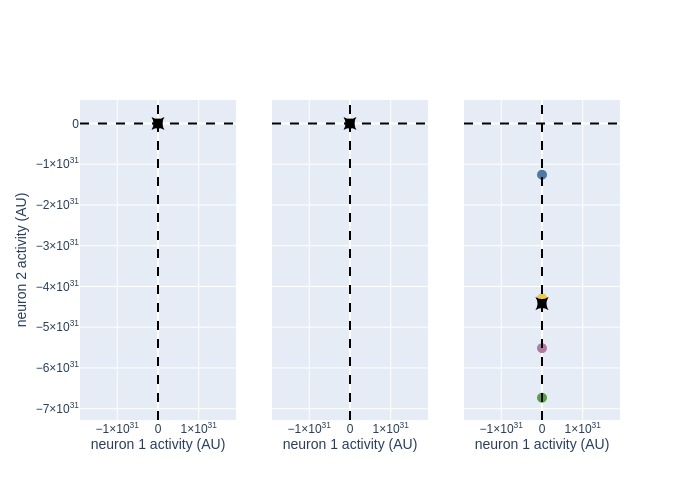

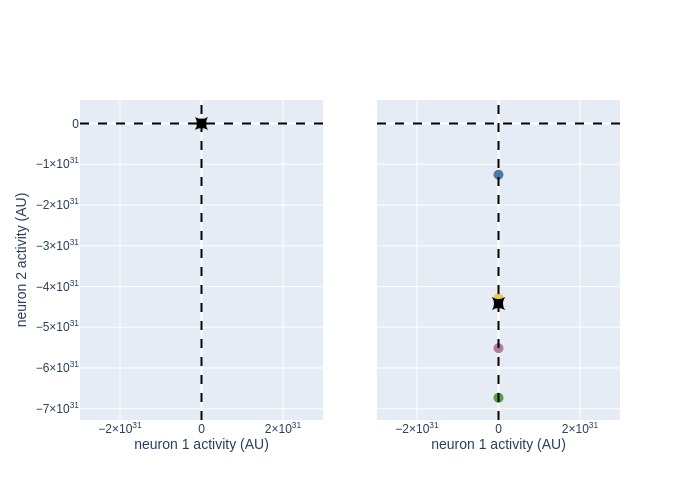

In [41]:
badcells = [0,1]
badprobe = 2
badtime = 6
# select a problematic subset: 2 neurons, 1 probe, 1 time point
bad_raster = raster[:,np.asarray(badcells),...][...,badprobe,badtime][:,:,:,None,None]
simp_diag = simple_diag[:,np.asarray(badcells),...][...,badprobe,badtime][:,:,:,None,None]
bad_diag = fano_diag[:,np.asarray(badcells),...][...,badprobe,badtime][:,:,:,None,None]


fig = plot_eg_diag([
    # bad_raster,
    bad_raster.mean(axis=0, keepdims=True),
    # simp_diag,
    simp_diag.mean(axis=0, keepdims=True),
    # bad_diag,
    bad_diag.mean(axis=0, keepdims=True)
])

fig.show(renderer='jpeg')
fig = plot_eg_diag([bad_raster, bad_diag])
fig.show(renderer='jpeg')

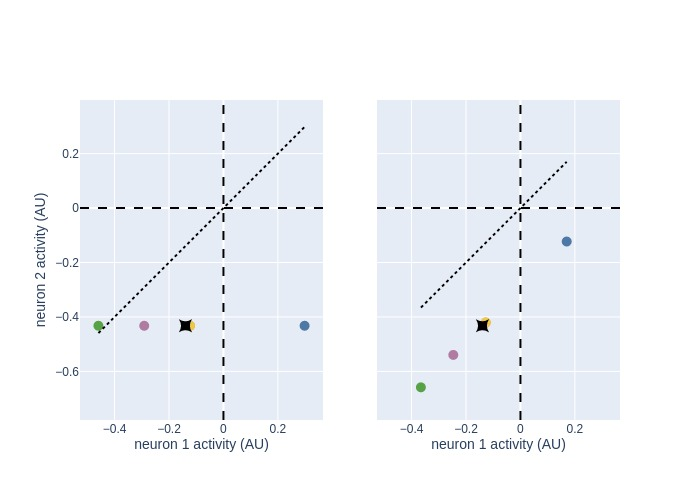

# All sites

same pipeline for all sites

In [6]:
# quick cache
acc_df_file = pl.Path(config['paths']['analysis_cache']) / f'230220_SC_decoder_accuracies'

recache_acc = False

if acc_df_file.exists() and not recache_acc:
    print('DF cache found, reloading')
    accuracy_df = jl.load(acc_df_file)

elif (not acc_df_file.exists()) or recache_acc:
    print('creating DF of site decoder accuracies ...')
    accuracy_df = list()
    for site in good_sites:
    # for site in [eg_site]:
        fn = load_site_formated_raster
        if fn.check_call_in_cache(site, **raster_meta):
            print(f'cache found for {site}')
            raster, _ = fn(site, **raster_meta)
        else:
            print(f"cant load {fn} with {raster_meta}.\n this should be cached, why is it failing? ")


        # diagonalizer = get_diagonalizations(raster)
        nsounds = raster.shape[3]
        codes = dict(sparse= raster,
                     dense = diag_and_scale(raster, mode='mean_var'),
                     dense_fano = diag_and_scale(raster, mode='fano_var')
                     )

        for code, rast in codes.items():
            unfolded, labels = unfold_rep_ctx_prb(rast)
            for part in ['context', 'probe']:
                accuracy, chance = get_svm_accuracy(unfolded, labels[part])

                d = {'site': site,
                     'code': code,
                     'part': part,
                     'accuracy': accuracy,
                     'chance': chance,
                     'nsounds': nsounds}

                accuracy_df.append(d)

    accuracy_df = pd.DataFrame(accuracy_df)
    print('... done creating DF')

    jl.dump(accuracy_df, acc_df_file)

DF cache found, reloading


### plots the cumulative data
lets see how the decoder analysis performs for all sites in their starting sparse encoding, and then once transformed
to the different dense codes

In [7]:
folder = root_path / 'reports' / 'figures' / 'decoder'
folder.mkdir(parents=True, exist_ok=True)

In [8]:

part = 'context'
code = 'sparse'
nsounds = 4

def plot_acc_from_df(fnDF, part, code, nsounds, color='black', showlegend=False):
    fig = go.Figure()
    indf = fnDF.query(f"part=='{part}' and code=='{code}' and nsounds=={nsounds}")
    chance = indf.chance.unique()[0]
    arr = np.stack(indf.loc[:, 'accuracy'].values)

    t = np.linspace(0, 1, arr.shape[1], endpoint=False)  # hardcoded 0 to 1 timeframe, fine for now
    # individual lines, damn you plotly for this verbose monster
    for l in arr:
        fig.add_trace(
            go.Scatter(x=t, y=l, mode='lines', opacity=0.3, showlegend=False,
                       line=dict(color=add_opacity(name_to_hex('gray'), 0.3)),
                       )
        )

    # mean of all lines
    fig.add_trace(
            go.Scatter(x=t, y=arr.mean(axis=0), mode='lines', showlegend=showlegend,
                       line=dict(color=color), name=f'{part}_{code}'
                       )
        )

    # chance line
    fig.add_trace(
            go.Scatter(x=[t[0],t[-1]], y=[chance]*2, mode='lines', showlegend=showlegend,
                       line=dict(color=color, dash='dot'), name=f'chance={chance}'
                       )
        )

    return fig

# fig = plot_acc_from_df(accuracy_df, part, code, nsounds, color='salmon')
# fig.show(renderer='jpeg')

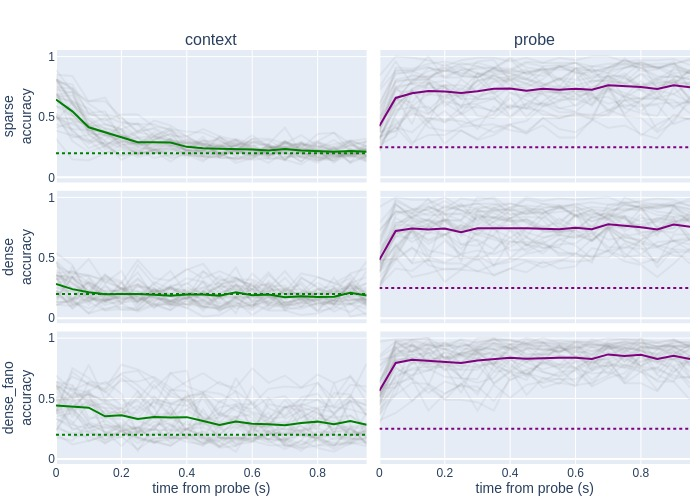

In [9]:
encodings = ['sparse', 'dense', 'dense_fano']
parts = ['context', 'probe']

fig = make_subplots(rows=3, cols=2, shared_xaxes='all', shared_yaxes='all', subplot_titles= parts + ['','','','',],
                    vertical_spacing=0.02, horizontal_spacing=0.02)


for cc, (part, color) in enumerate(zip(parts, ['green', 'purple'])):
    for rr, code in enumerate(encodings):
         f = plot_acc_from_df(accuracy_df, part, code, nsounds=4, color=color)['data']
         fig.add_traces(f, rows=[rr+1]*len(f), cols=[cc+1]*len(f))


fig.update_layout(margin={'t':50, 'l':50, 'b': 10, 'r': 10})

for rr, code in enumerate(encodings):
    fig.update_yaxes(title=dict(text=f'{code}<br>accuracy', standoff=0),
                     row=rr+1, col=1)
for cc in range(1,3):
    fig.update_xaxes(title=dict(text='time from probe (s)', standoff=0),
                     row=3, col=cc)

filename = folder / 'all_4sound_sites_accuracy'
fig.write_image(filename.with_suffix('.png'), scale=1)

fig.show(renderer='jpeg')

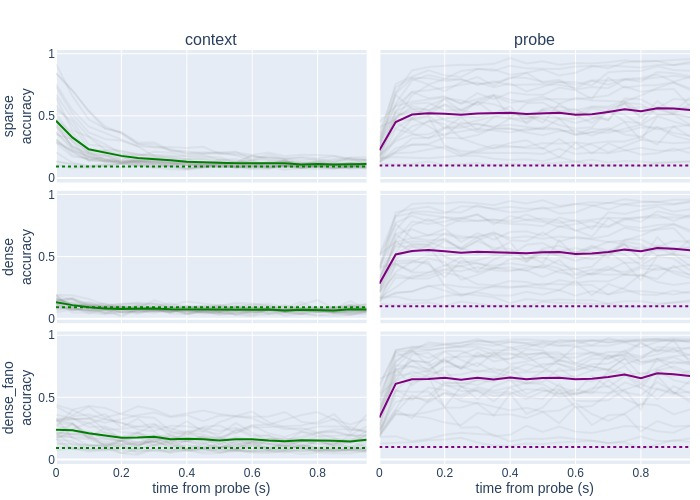

In [10]:
encodings = ['sparse', 'dense', 'dense_fano']
parts = ['context', 'probe']

fig = make_subplots(rows=3, cols=2, shared_xaxes='all', shared_yaxes='all', subplot_titles= parts + ['','','','',],
                    vertical_spacing=0.02, horizontal_spacing=0.02)


for cc, (part, color) in enumerate(zip(parts, ['green', 'purple'])):
    for rr, code in enumerate(encodings):
         f = plot_acc_from_df(accuracy_df, part, code, nsounds=10, color=color)['data']
         fig.add_traces(f, rows=[rr+1]*len(f), cols=[cc+1]*len(f))


fig.update_layout(margin={'t':50, 'l':50, 'b': 10, 'r': 10})

for rr, code in enumerate(encodings):
    fig.update_yaxes(title=dict(text=f'{code}<br>accuracy', standoff=0),
                     row=rr+1, col=1)
for cc in range(1,3):
    fig.update_xaxes(title=dict(text='time from probe (s)', standoff=0),
                     row=3, col=cc)

filename = folder / 'all_10sound_sites_accuracy'
fig.write_image(filename.with_suffix('.png'), scale=1)

fig.show(renderer='jpeg')